In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression as LogReg
import time
from __future__ import division

# Load and organize the data

In [5]:
# Load the data

# Inspections
insp = pd.read_csv('../data/Food_Inspections_Clean2.csv')
insp['date'] = pd.to_datetime(insp['Inspection Date'].astype('str'),infer_datetime_format=True)
insp.loc[:,'day_of_week']=insp.date.dt.dayofweek.values
insp.loc[:,'day_of_year']=insp.date.dt.dayofyear.values
insp.rename(columns={'License #':'license','Inspection ID':'ID','Facility Type':'facility','Inspection Type':'inspection_type'},
            inplace=True)
insp_all = insp.copy()
insp = insp[['ID','license','date','Results','Risk','facility','inspection_type',
             'month','day','year','day_of_week','day_of_year','Latitude','Longitude','Zip']]

# Weather
weath_big = pd.read_csv('../data/Weather_clean.csv',parse_dates=[6])
weath = weath_big[['date','tmax','tavg']]

# Complaints
comp_big = pd.read_csv('../data/311_clean.csv',parse_dates=[0,2])
#comp = comp_big[['created','nature','zip','longitude','latitude','ward','police district','community area']]
comp = comp_big[['created','nature','longitude','latitude']]

In [7]:
# Convert longitude,latitude pairs to x-y coordinates.
# I arbitrarily made a reference point (0,0) at -88,41.  This is slightly southwest of the city.
# Then, I converted long,lat coordinates to x,y in kilometers:

long_ref,lat_ref = -88,41
lat_to_km = 111.07
long_to_km = 83.00733

def longlat2xy(longitude,latitude):
    x = (longitude-long_ref)*long_to_km
    y = (latitude-lat_ref)*lat_to_km
    return x,y

# Convert the locations in inspections and complaints.
insp.loc[:,'x'],insp.loc[:,'y'] = longlat2xy(insp['Longitude'].values,insp['Latitude'].values)
comp.loc[:,'x'],comp.loc[:,'y'] = longlat2xy(comp['longitude'].values,comp['latitude'].values)

# Filter Inspections:

### Include only the following:
* Results exist (already done in the cleaning)
* Inspection type is 
    * Canvass
    * Complaint
    * Short Form Complaint
    * Suspected Food Poisoning
* Facility type is
    * Restaurant
    * Grocery Store
    * Bakery
* License exists
* Location exists

In [8]:
n_all = insp.shape[0]
print 'number of records with inspection results: {:,}'.format(n_all)

number of records with inspection results: 118,102


In [9]:
# Filter inspection types
print "Most common Inspection types in the raw data:"
print insp.inspection_type.value_counts(dropna=False).head(10)

insp = insp.query('inspection_type in ["Canvass","Complaint","Short Form Complaint","Suspected Food Poisoning"]')
print "\n\n\nInspection types after filtering:"
print insp.inspection_type.value_counts(dropna=False).head(10)

Most common Inspection types in the raw data:
Canvass                     55858
License                     16811
Canvass Re-Inspection       12686
Complaint                   11912
License Re-Inspection        6601
Short Form Complaint         5271
Complaint Re-Inspection      5018
Suspected Food Poisoning      646
Consultation                  635
Tag Removal                   603
Name: inspection_type, dtype: int64



Inspection types after filtering:
Canvass                     55858
Complaint                   11912
Short Form Complaint         5271
Suspected Food Poisoning      646
Name: inspection_type, dtype: int64


In [10]:
# Filter facility types
print "Most common Facility types in the raw data:"
print insp.facility.value_counts(dropna=False).head(10)

insp = insp.query('facility in ["Restaurant","Grocery Store","Bakery"]')
print "\n\n\nFacility types after filtering:"
print insp.facility.value_counts(dropna=False).head(10)

Most common Facility types in the raw data:
Restaurant                         51953
Grocery Store                       8846
School                              6499
Bakery                              1071
Daycare (2 - 6 Years)                615
Long Term Care                       499
Daycare Above and Under 2 Years      452
Catering                             396
Children's Services Facility         337
Golden Diner                         283
Name: facility, dtype: int64



Facility types after filtering:
Restaurant       51953
Grocery Store     8846
Bakery            1071
Name: facility, dtype: int64


In [11]:
# Drop records with no license.
insp = insp[insp.license.notnull()]

In [12]:
# Drop records with no location.
insp = insp[insp.Latitude.notnull()]

In [13]:
n_rem = insp.shape[0]
print 'After filtering, there are {:,} records remaining ({}%)'.format(n_rem,round(100.*n_rem/n_all,2))

After filtering, there are 61,727 records remaining (52.27%)


# Examine the features of the inspections

### Examine day-of-week

In [23]:
# Which days are inspections?
print "Inspections breakdown by day of the week (0:Monday, 1:Tuesday, etc.) (%)"
print (insp.day_of_week.value_counts(normalize=True)*100).round(2).sort_index()
# They are most often Tues & Thurs, but still very commonly M,W,F.  Sat and Sun are very rare, with only 5 happening on Sunday.

Inspections breakdown by day of the week (0:Monday, 1:Tuesday, etc.) (%)
0    17.93
1    21.09
2    18.48
3    22.34
4    20.12
5     0.03
6     0.01
Name: day_of_week, dtype: float64


C:\Users\Andrew\Anaconda2\lib\site-packages\matplotlib\transforms.py:660: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


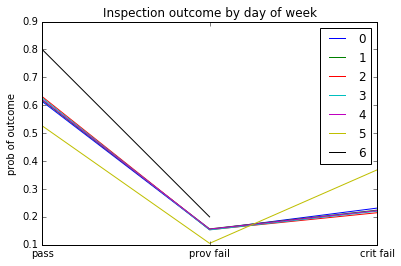

In [19]:
# What are the outcomes of the inspection by day?
v = insp.groupby('day_of_week').Results.value_counts(normalize=True).unstack()
plt.plot(v.values.T)
plt.legend(np.arange(7),loc='best')
plt.xticks(range(3),('pass','prov fail','crit fail'))
plt.ylabel('prob of outcome')
plt.title('Inspection outcome by day of week')
plt.show()

Looks like only Saturdays have different outcomes, and they are very rare anyway.  Therefore, I don't expect day of week to have much of an effect.

### Examine Month of Year

Inspection outcome by month (%)
1     8.30
2     7.68
3     9.11
4     8.61
5     8.77
6     9.27
7     7.96
8     9.53
9     8.75
10    8.52
11    7.05
12    6.45
Name: month, dtype: float64


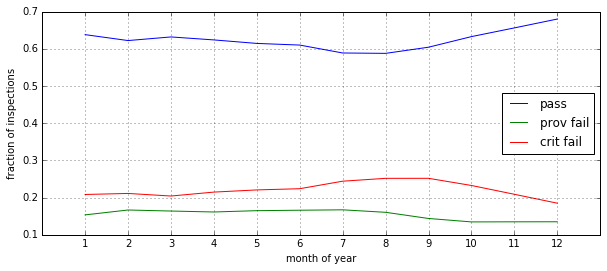

In [26]:
# Frequency of inspections by month and their outcomes
print "Inspection outcome by month (%)"
print (insp.month.value_counts(normalize=True)*100).round(2).sort_index()
v = insp.groupby('month').Results.value_counts(normalize=True).unstack()
plt.figure(figsize=(10,4))
plt.plot(v)
plt.grid('on')
plt.xlim([0,13])
plt.legend(('pass','prov fail','crit fail'),loc='best')
plt.xticks(np.arange(1,13))
plt.xlabel('month of year')
plt.ylabel('fraction of inspections')
plt.show()

There is a small dip in the passes in the summer (july/august/september), with a rise in both failures but especially critical failures.  
Converely, November and December seem protective compared to Jan-June.  

This could point to a weather effect.  However, it could arise from many other reasons.  e.g Maybe there is more street food in the summer and that is dangerous.

### Examine zip code
Using zip as a location encoder for these baseline models.

In [27]:
# There are 100 unique zip codes in the data.  
zips = insp.Zip.unique()
zips.sort()
zips,len(zips)

(array([ 60601.,  60602.,  60603.,  60604.,  60605.,  60606.,  60607.,
         60608.,  60609.,  60610.,  60611.,  60612.,  60613.,  60614.,
         60615.,  60616.,  60617.,  60618.,  60619.,  60620.,  60621.,
         60622.,  60623.,  60624.,  60625.,  60626.,  60628.,  60629.,
         60630.,  60631.,  60632.,  60633.,  60634.,  60636.,  60637.,
         60638.,  60639.,  60640.,  60641.,  60642.,  60643.,  60644.,
         60645.,  60646.,  60647.,  60649.,  60651.,  60652.,  60653.,
         60654.,  60655.,  60656.,  60657.,  60659.,  60660.,  60661.,
         60666.,  60707.,  60827.,     nan]), 60)

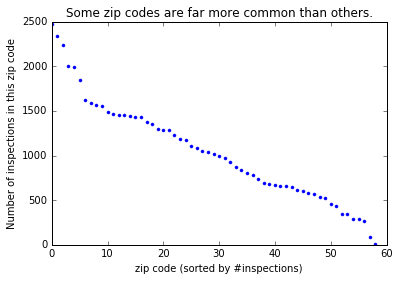

In [28]:
# However, some of the zip codes do not occur with much regularity.
v = insp.Zip.value_counts(normalize=False)
plt.plot(v.values,'.')
plt.ylabel('Number of inspections in this zip code')
plt.xlabel('zip code (sorted by #inspections)')
plt.title('Some zip codes are far more common than others.')

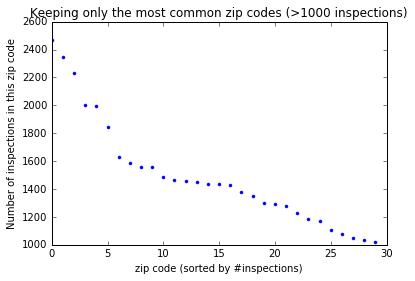

In [108]:
# I'm making a new filed, zip2, in which all the rare zips are replaced by nans.
insp.loc[:,'zip2'] = insp.Zip
smallzip_idx = insp.zip2.value_counts()<1000
smallzips = smallzip_idx.index[smallzip_idx]
insp.ix[insp.zip2.isin(smallzips),'zip2']=np.nan

v = insp.zip2.value_counts(normalize=False)
plt.plot(v.values,'.')
plt.ylabel('Number of inspections in this zip code')
plt.xlabel('zip code (sorted by #inspections)')
plt.title('Keeping only the most common zip codes (>1000 inspections)')

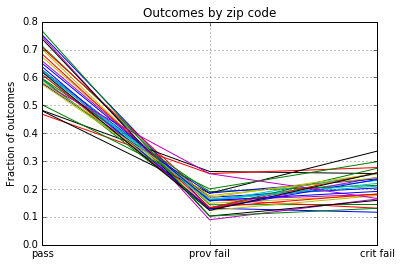

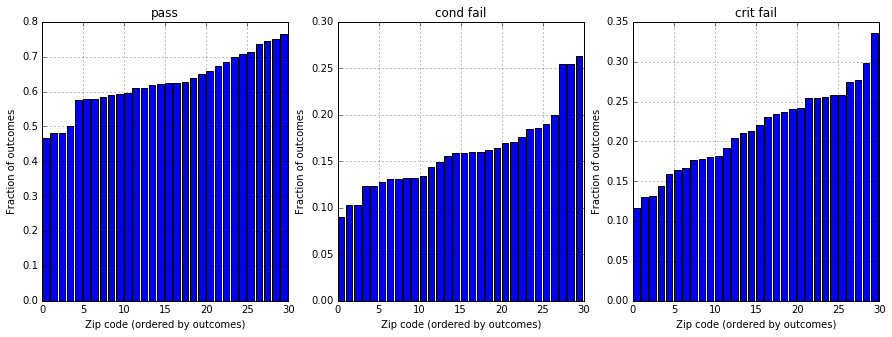

In [109]:
# There is some heterogeneity to the inspection outcome by zip code
v = insp.groupby('zip2').Results.value_counts(normalize=True).unstack()
plt.plot(v.T)
plt.grid('on')
plt.ylabel('Fraction of outcomes')
plt.xticks(range(3),('pass','prov fail','crit fail'))
plt.title('Outcomes by zip code')
plt.show()

fig,ax = plt.subplots(1,3,figsize=(15,5))
titles = ('pass','cond fail','crit fail')
for i in range(v.shape[1]):
    v2 = v.values[:,i]
    v2.sort()
    ax[i].bar(np.arange(v.shape[0]),v2)
    ax[i].grid('on')
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('Fraction of outcomes')
    ax[i].set_xlabel('Zip code (ordered by outcomes)')

In fact, there is a factor of 3 difference between the zips with the least and most critical failures.  This is similar for the conditional fails.

### Examine Risk score

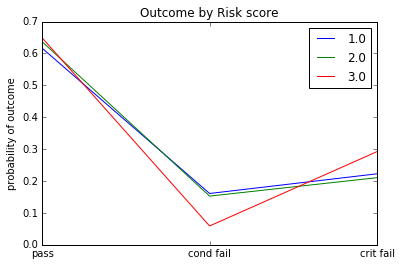

In [110]:
v = insp.groupby('Risk').Results.value_counts(normalize=True).unstack()
plt.plot(v.T)
plt.legend(v.index)
plt.title('Outcome by Risk score')
plt.ylabel('probability of outcome')
plt.xticks(range(3),('pass','cond fail','crit fail'))
plt.show()

Risk-3 inspections are much more likely to result in a critical failure, mostly coming from a decreased probability of a conditional failure but they are also somewhat less likely to pass.  This is surprising since these are the least risky establishments; they do not handle raw ingredients.

### Examine inpection types
We are only examining Canvass (regular inspections), Complaints, and Suspected Food Poisonings.  We are considering these because these are the inspections that the city has some discretion in scheduling.

In [35]:
# How many types are there?
len(insp['inspection_type'].unique())

4

In [39]:
# How common is each type?  This is % of inspections.
(insp['inspection_type'].value_counts(normalize=True)*100).round(1)

Canvass                     72.6
Complaint                   18.2
Short Form Complaint         8.2
Suspected Food Poisoning     1.0
Name: inspection_type, dtype: float64

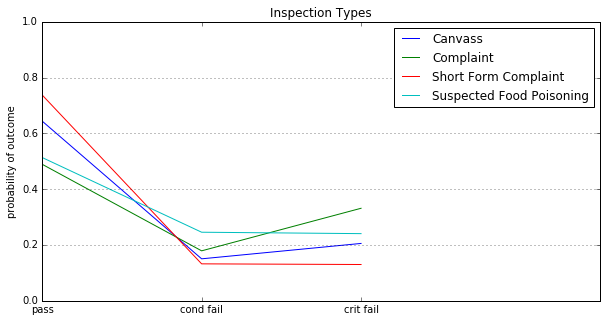

In [42]:
# Plot the inpection outcomes by type

v = insp.groupby('inspection_type').Results.value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(10,5))
plt.plot(v.values.T)
plt.legend(v.index)
plt.xlim([0,3.5])
plt.ylim([0,1])
plt.title('Inspection Types')
plt.ylabel('probability of outcome')
plt.xticks(range(3),('pass','cond fail','crit fail'))
plt.grid(axis='y')
plt.show()

There is a fair bit of heterogeneity here, with suspected food poisoning being the most likely to fail.  Complaints are slightly more likely to fail than canvasses; surprisingly, short-form complaints are less likely to fail than a canvass.

### Examine Facility Type

There are a lot of facility types.  However, we are only considering 3: Restaurant, Grocery Store, and Bakery.  Together, these account for the majority of the data (83%).  The biggest omissions are hospitals and schools, which we expect to be governed by different rules (i.e. the model likely would not apply; another should be built for these cases).



In [46]:
# prevalence of the first 50 types
(insp['facility'].value_counts(normalize=True)*100).round(2).head(50)

Restaurant       83.97
Grocery Store    14.29
Bakery            1.74
Name: facility, dtype: float64

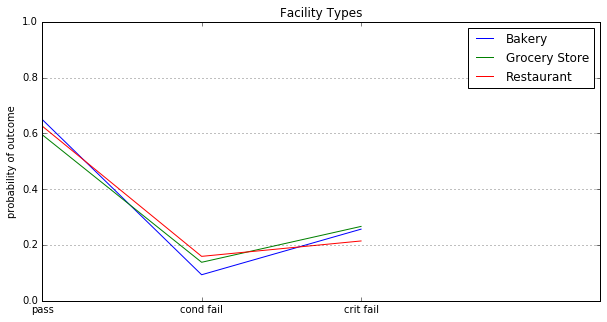

In [48]:
# plot the inspection outcomes by facility types

v = insp.groupby('facility').Results.value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(10,5))
plt.plot(v.values.T)
plt.legend(v.index)
plt.xlim([0,3.5])
plt.ylim([0,1])
plt.title('Facility Types')
plt.ylabel('probability of outcome')
plt.xticks(range(3),('pass','cond fail','crit fail'))
plt.grid(axis='y')
plt.show()



There is reasonable some heterogeneity by facility type, but not as much as by inspection type.  
Surprisingly, bakeries are just as likely to have critical failures as restaurants.


# Make performance metric
As a perforamnce metric, we are using the likelihood.  This is the likelihood of the data given the model-predicted probabilities of each outcome.  

For computational reasons, we are using the negative log likelihood as a loss function.  We want to maximize the likelihood, so also maximize the log likelihood, so minimize the negative log likelihood (hence why it's a loss function).  This is computationally better becuase each observation then adds a positive number, generally of order of magnitude around 1.  This is much less likely to hit machine precision issues than multiplying many numbers smaller than 1, which gets quite small quite fast.  

I am then taking the average loss (i.e. total loss of all observations divided by the number of observations).  Finally, to make this number more intuitive, I am converting it back to a characteristic probability (by negating and exponentiating).  This corresponds to the "average" probability of an outcome occuring, i.e. how likely the average outcome was based on the model.  

See here for more details: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss

Technical note: I shrunk the class probabilities so no class had probability 0.  This is so that even bins with no observations of a certain type won't make the negative loss go to infinity.  I thus made all bins have a floor of 0.01 (and scaled the bins to still add to 1).


In [111]:
# For Ytrue (integers specifying class) and Ypred (n x m array of probabilities),
# calculate the negative log loss (i.e. neg log likelihood)

# Return the tuple (average neg log loss, characteristic probability)
def log_loss(Ytrue,Ypred):
    badidx = np.isnan(Ytrue)
    Ytrue = Ytrue[~badidx]
    Ypred = Ypred[~badidx,:]
    n,m = Ypred.shape
    
    if not np.issubdtype(Ytrue.dtype,np.integer):
        Ytrue = Ytrue.copy().astype('int')
    
    # p is the predicted probability of the event that happened
    p = Ypred[np.arange(n),Ytrue]
    # A hack to avoid being certain something will never happen
    # This sets the minimum value to 0.01
    x = 0.01031
    p = (p+x)/(1+3*x)
    
    ave_loss = -np.log(p).mean()
    char_p = np.exp(-ave_loss)
    return ave_loss,char_p
    

In [112]:
# Explore the log_loss function.

print 'When all outcomes had the same prediction, the characterisitic p-value is that prediction value '
print '(except slightly off because of the floor I added)'
b = np.ones((12,3))*np.array([0.9,0.1,0])
a = np.ones(12,dtype='int')
print log_loss(a,b)

print '\nThis does not depend on the number of observations:'
# Validate that this works
b = np.ones((12,3))*np.array([0.9,0.1,0])
a = np.ones(12,dtype='int')
a[0::2] = 0
print 'using 2 values repeated 6 times:', log_loss(a,b)

# Doesn't matter how many things there are
print 'using 2 values:', log_loss(a[:2],b[:2])


When all outcomes had the same prediction, the characterisitic p-value is that prediction value 
(except slightly off because of the floor I added)
(2.2349220024833505, 0.10700047529900185)

This does not depend on the number of observations:
using 2 values repeated 6 times: (1.179676694053827, 0.30737809970560598)
using 2 values: (1.1796766940538272, 0.30737809970560592)


# Make baseline models

### Baseline 0:
The first baseline model is just to use the probabilities of each outcome.

### Baseline 1:
The second baseline is to use:
* the day of the week 
* the month of the year 
* the zip code  
, averaged across all years.

In [113]:
# Baseline probabilities
(insp.Results.value_counts(normalize=True)*100).round(2).sort_index()

0.0    62.22
1.0    15.51
2.0    22.27
Name: Results, dtype: float64

In [114]:
# Define the first baseline model.  
# Regardless of inspection, it predicts the baseline probabilities.
class baseline_probabilities():
    def __init__(self):
        self._weekdays = None
        self._weekends = None
    
    def fit(self,X):
        self._blprob = X.Results.value_counts(normalize=True).sort_index().values.reshape(1,3)
    
    def predict_proba(self,X):
        n = X.shape[0]
        proba = self._blprob.repeat(n,axis=0)
        return proba
    

In [115]:
# Predict using observations with the same day of the week, zip code, and month.
# Where the zip code is not available, omit location (marginalize over all zips)
# When it is a weekend, ignore zip and month and consider saturdays and sundays the same -- 
# there aren't enough weekend observations to support anything more.  

class average_past_years():
    def __init__(self):
        self._weekdays = None
        self._weekends = None
    
    def fit(self,X):
        self._weekdays = X.groupby(['zip2','month','day_of_week']).Results.value_counts(normalize=True).unstack().fillna(0)
        self._nozip = X.groupby(['month','day_of_week']).Results.value_counts(normalize=True).unstack().fillna(0)
        temp = X.groupby(['day_of_week']).Results.value_counts().unstack().fillna(0).ix[5:6,:].sum()
        self._weekends = temp/sum(temp)
    
    def predict_proba(self,X):
        tuple_raw = X[['zip2','month','day_of_week']].values
        proba = np.empty((X.shape[0],self._weekdays.shape[1]))
        print proba.shape
        for i,r in enumerate(X.index):
            t = tuple(tuple_raw[i,:])
            if t[2]>4:
                proba[i,:] = self._weekends.values
            elif np.isnan(t[0]):
                proba[i,:] = self._nozip.ix[t[1:]]
            else:
                proba[i,:] = self._weekdays.ix[t,:].values
        return proba
    

In [116]:
tuple_raw = insp[['zip2','month','day_of_week']].values
type(tuple_raw),tuple_raw.shape

(numpy.ndarray, (61727L, 3L))

In [117]:
# See how well baseline 0 describes all the data.
m0 = baseline_probabilities()
m0.fit(insp)
r = m0.predict_proba(insp)
m0_in_sample_fits = log_loss(insp.Results.values,r)
print 'BASELINE 0 FIT ON ALL DATA:'
print 'loss={}, characteristic probability={}:'.format(*np.round(m0_in_sample_fits,2))

BASELINE 0 FIT ON ALL DATA:
loss=0.92, characteristic probability=0.4:


In [118]:
%%time

m1 = average_past_years()
m1.fit(insp)
r = m1.predict_proba(insp)
m1_in_sample_fits = log_loss(insp.Results.values,r)
m1_in_sample_fits
print 'BASELINE 1 FIT ON ALL DATA:'
print 'loss={}, characteristic probability={}:'.format(*np.round(m1_in_sample_fits,2))

(61727L, 3L)
BASELINE 1 FIT ON ALL DATA:
loss=0.87, characteristic probability=0.42:
Wall time: 10.5 s


As expected, the second baseline fits the data better since it describes the data in more granularity.  However, this does not mean it generalizes better to data it was not fit on.  To test that, we cross-validate.


In [138]:
insp_ridx = insp.reset_index()
print insp_ridx.shape

(61727, 20)


In [165]:
#%%time

# Apologies here: I couldn't get the code to work after filtering the data, which reduced by by 50%.
# We know from running this on the unfiltered data (see Milestone 4) that this method, of predicting
# based on the same zip, day of week, and year, badly overfits the data.  The good fit to all the data
# does not carry over to the cross-validated data.  
# This is also why I am having trouble getting it to work -- often predictions are made based on very
# few observations -- sometimes even 0!

# n = insp_ridx.shape[0]
# n_folds = 5
# kf = TimeSeriesSplit(n_splits=n_folds)

# mll0 = np.empty(n_folds)
# charp0 = np.empty_like(mll0)
# mll1 = np.empty_like(mll0)
# charp1 = np.empty_like(mll0)

# # Loop through the folds of the 10-fold CV
# for i,(ktrain,ktest) in enumerate(kf.split(insp_ridx)):
#     train = insp_ridx.ix[ktrain,:]
#     test = insp_ridx.ix[ktest,:]
    
#     # Fit baseline model 1
#     mdl1 = average_past_years()
#     mdl1.fit(train)
#     Ypred = mdl1.predict_proba(test)
# #     mll1[i],charp1[i] = log_loss(test.Results.values,Ypred)
    
#     # Fit baseline model 0
#     mdl0 = baseline_probabilities()
#     mdl0.fit(train)
#     Ypred = mdl0.predict_proba(test)
#     mll0[i],charp0[i] = log_loss(test.Results.values,Ypred)


In [166]:
# Plot the results

# plt.figure(figsize=(10,5))
# for i in range(2):
#     plt.subplot(1,2,i+1)
#     plt.bar(0,charp0.mean())
#     plt.bar(1,charp1.mean())
#     plt.ylim([0.41,0.46])
#     plt.grid(axis='y')
#     plt.xlim([-0.2,2])
#     plt.plot(0.4*np.ones_like(charp0),charp0,'r.',markersize=15)
#     plt.plot(0.4,m0_in_sample_fits[1],'g.',markersize=15)
#     plt.plot(1.4*np.ones_like(charp1),charp1,'r.',markersize=15)
#     plt.plot(1.4,m1_in_sample_fits[1],'g.',markersize=15)
#     plt.xticks([0.4,1.4],('baseline probabilities','by zip, weekday, month'),rotation=10)
#     plt.title('zoomed in')
#     if i==0:
#         plt.ylim([0,1])
#         plt.ylabel('Characteristic p')
#         plt.legend(('out-of-sample','in-sample'),numpoints=1)
#         plt.title('performance of baseline models 0 and 1')

We see that, despite the more detailed describing the in-sample data better (green dot up at 0.45), it actually does worse at predicting the out-of-sample data from the cross-validation.  

This difference between in-sample and out-of-sample performance is indicative of overfitting: we are dividing the data too finely and ignoring data from other groups that helps with predictions.

Thus, despite its simplicity, baseline 0 is actually the better model.

# Logistic Regression models
Let's extend this simple averaging approach to using logistic regression to predict class outcomes.

We expect this to be helpful because we can consider main effects of each of the above features without interactions, so we reduce our chances of overfitting dramatically.

We can also add the other inspection features to these models (made possible again by reduced overfitting by considering only main effects here).

In [193]:
# make dummies of day-of-week, month, year, zip, risk, inspection type, and facility type
dow_dummy = pd.get_dummies(insp.day_of_week,prefix='day',drop_first=True)
month_dummy = pd.get_dummies(insp.month,prefix='month',drop_first=True)
year_dummy = pd.get_dummies(insp.year,prefix='year',drop_first=True)
zip_dummy = pd.get_dummies(insp.zip2)
risk_dummy = pd.get_dummies(insp.Risk,prefix='risk',dummy_na=True,drop_first=True)
it_dummy = pd.get_dummies(insp.inspection_type,prefix='it')
ft_dummy = pd.get_dummies(insp.facility,prefix='ft')

In [194]:
# Get the outcomes of the inspections;
# Delete the rows with missing outcomes.
Yall = insp.Results.values
badidx = np.isnan(Yall)
Y = Yall[~badidx]

In [195]:
%%time
# First models: variants using the day of the week, month, and zip code. 
# These are analogous to baseline 1 above.

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','dow_month','dow_month_year','dow_month_zip','dow_month_zip_year']
n_models = len(model_names)

# Define the predictors for each model
temp = pd.concat((dow_dummy,month_dummy),axis=1).values
X1 = temp[~badidx,:]
X0 = (X1[:,0]*0+1).reshape(-1,1)
temp = pd.concat((dow_dummy,month_dummy,year_dummy),axis=1).values
X2 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy),axis=1).values
X3 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,year_dummy),axis=1).values
X4 = temp[~badidx,:]

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 5.12 s


In [196]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

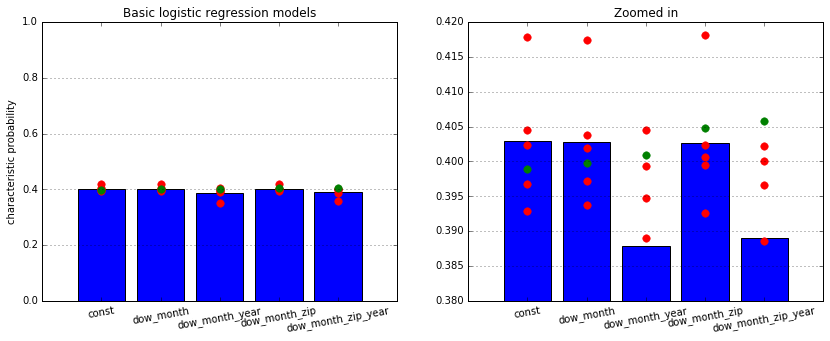

In [197]:
# Plot the characteristic probability for each of the models

plt.figure(figsize=(14,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Basic logistic regression models')
    if i==1:
        plt.ylim([0.38,0.42])
        plt.title('Zoomed in')
    else:
        plt.ylabel('characteristic probability')
plt.show()

Adding just the day of the week did not help much; surpringly, adding the year hurt substantially.  This is because, with the TimeSeriesCV methodology, there is often very little training data for the year for which we are making predictions, as it only trains on the "past" to test on the "future".  

None of these substantially outperform a baseline model.

Note that none of these models (aside from the ones with year) had a gap between CV performance (red dots) and in-sample perforamnce (green dots).  Thus, unlike baseline 1 above, these models are not overfitting.  They all perform worse than baseline 1 in-sample but all bettter out-of-sample. In fact, they are preferred do baseline 0 (same as const here) for out-of-sample.

In [198]:
%%time

# Make logistic models of each factor alone

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','dow','month','year','zip',
               'risk','it','ft']
n_models = len(model_names)

# Define the predictors for each model
temp = dow_dummy.values
X1 = temp[~badidx,:]
X0 = (X1[:,0]*0+1).reshape(-1,1)
temp = month_dummy.values
X2 = temp[~badidx,:]
temp = year_dummy.values
X3 = temp[~badidx,:]
temp = zip_dummy.values
X4 = temp[~badidx,:]
temp = risk_dummy.values
X5 = temp[~badidx,:]
temp = it_dummy.values
X6 = temp[~badidx,:]
temp = ft_dummy.values
X7 = temp[~badidx,:]

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 2.77 s


In [199]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

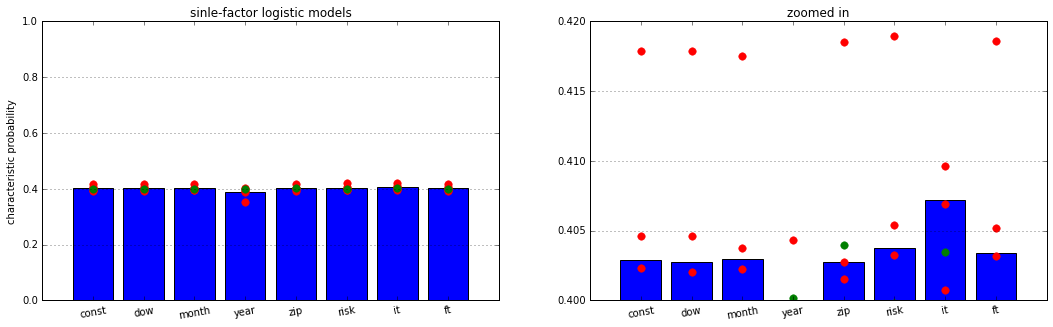

In [200]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('sinle-factor logistic models')
    if i==1:
        plt.ylim([0.40,0.42])
        plt.title('zoomed in')
    else:
        plt.ylabel('characteristic probability')
plt.show()

As we saw before, year is problematic.  

Zip and month may add a little, but it is marginal.  

Strikingly, the Inspection Type adds the most value by far.  

Risk and facility type also add moderate value.

I will now put these together:

In [208]:
%%time

# Make logistic models adding factors to the dow-year-zip (time-place models)

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','dow_month','dow_month_zip',
               'time_place_risk','time_place_it','time_place_ft']
n_models = len(model_names)

# Define the predictors for each model
temp = pd.concat((dow_dummy,month_dummy),axis=1).values
X1 = temp[~badidx,:]
X0 = (X1[:,0]*0+1).reshape(-1,1)
temp = pd.concat((dow_dummy,month_dummy,zip_dummy),axis=1).values
X2 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,risk_dummy),axis=1).values
X3 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy),axis=1).values
X4 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,ft_dummy),axis=1).values
X5 = temp[~badidx,:]

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 6.44 s


In [209]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

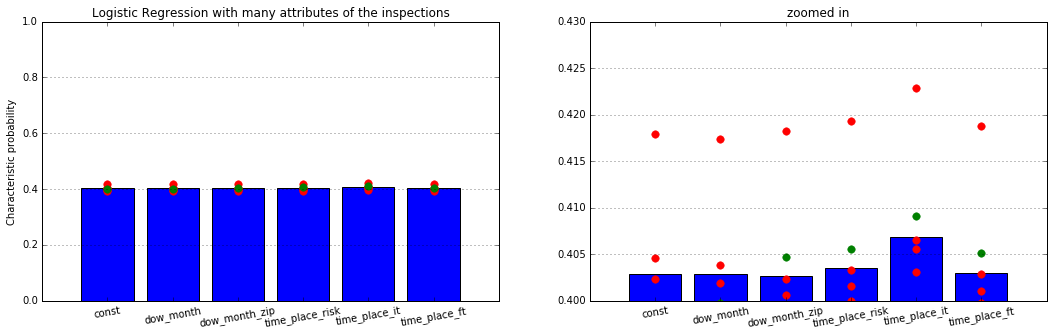

In [210]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with many attributes of the inspections')
    if i==1:
        plt.ylim([0.40,0.43])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

In [211]:
%%time

# Adding all the attributes at once

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','time_place_it','all']
n_models = len(model_names)

# Define the predictors for each model
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy),axis=1).values
X1 = temp[~badidx,:]
X0 = (X1[:,0]*0+1).reshape(-1,1)
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy,risk_dummy,ft_dummy),axis=1).values
X2 = temp[~badidx,:]

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 3.55 s


In [212]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

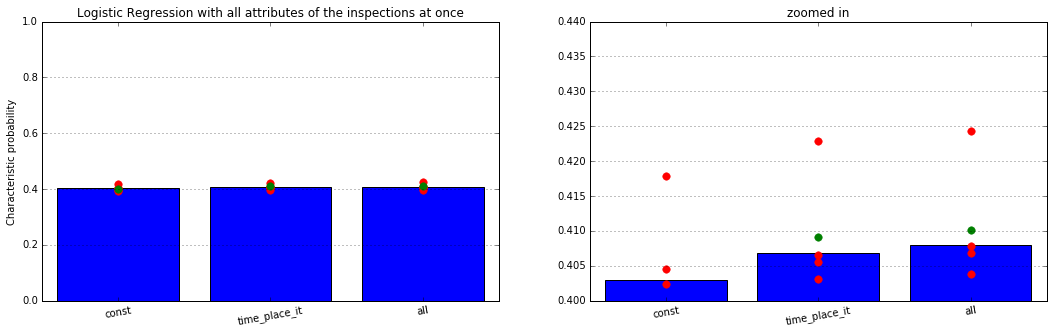

In [213]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with all attributes of the inspections at once')
    if i==1:
        plt.ylim([0.40,0.44])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

These models outperform the baseline models that only average observations (same as const above).  In fact, even with all the attributes included, there is no evidence of overfitting -- the in-sample fits (green dots) perform the same as the out-of-sample fits (red dots).  

Thus, the best model we have so far is to include all the attributes listed above in a logistic regression model (aside from year, of course).

# Format and explore weather and sanitation features

## Format the weather data

In [214]:
# Fill in the missing daily highs (the last 2 days) with the existing daily averages.
weath.ix[2494:2495,'tmax'] = weath.ix[2494:2495,'tavg']

# Make 1-week rolling average column
weath.ix[:,'tavg_week']=weath['tmax'].rolling(window=7,min_periods=1).mean()

# Preview the data
weath.ix[10:13,['date','tmax','tavg_week']]

,date,tmax,tavg_week
10,2010-01-11,26.0,22.571429
11,2010-01-12,31.0,23.714286
12,2010-01-13,35.0,25.857143
13,2010-01-14,40.0,28.428571


In [215]:
# add weather information to the inspection table
insp = pd.merge(insp,weath[['date','tmax','tavg_week']],how='left',on='date').set_index(insp.index)

In [216]:
insp.head(5)

,ID,license,date,Results,Risk,facility,inspection_type,month,day,year,...,day_of_year,Latitude,Longitude,Zip,x,y,zip2,it2,tmax,tavg_week
0,1970470,1909713.0,2016-10-28,1.0,1.0,Restaurant,Short Form Complaint,10,28,2016,...,302,41.966063,-87.657734,60640.0,28.410576,107.300617,60640.0,Short Form Complaint,65.0,59.000000
4,1970429,1620340.0,2016-10-28,2.0,1.0,Restaurant,Complaint,10,28,2016,...,302,41.961619,-87.673833,60640.0,27.074279,106.807061,60640.0,Complaint,65.0,59.000000
5,1951297,2349672.0,2016-10-28,0.0,2.0,Restaurant,Complaint,10,28,2016,...,302,41.883717,-87.626086,60602.0,31.037584,98.154431,NaN,Complaint,65.0,59.000000
7,1970406,1821870.0,2016-10-28,0.0,2.0,Grocery Store,Short Form Complaint,10,28,2016,...,302,41.851590,-87.729454,60623.0,22.457300,94.586088,60623.0,Short Form Complaint,65.0,59.000000
11,1970392,2074456.0,2016-10-27,1.0,1.0,Restaurant,Complaint,10,27,2016,...,301,41.718683,-87.681848,60643.0,26.408983,79.824081,NaN,Complaint,51.0,57.428571


## Format the complaints data

In [217]:
comp.head(5)

,created,nature,longitude,latitude,x,y
0,2011-01-01,Garbage in alley,-87.712791,41.949330,23.840440,105.442125
1,2011-01-01,Garbage in yard,-87.708757,41.936356,24.175274,104.001023
2,2011-01-01,Construction Site Cleanliness/Fence,-87.631146,41.892427,30.617553,99.121905
3,2011-01-01,Garbage in alley,-87.616318,41.711877,31.848449,79.068215
4,2011-01-01,Garbage in yard,-87.525750,41.701807,39.366256,77.949719


In [218]:
#%%time

# For each inspection, I will count the number of complaints within the last week and within a 0.5km radius.

# specify "close" in time and space
loc_dist = 0.5 #This is in km
loc_hist = pd.Timedelta(7, unit='d')

# pre-define the relevant sanitation and inspection data
insp_locs,insp_d = insp[['x','y']],insp['date']
san_x,san_y,san_d = comp['x'],comp['y'],comp['created']

# Loop through inspections; for each, find all the nearby recent sanitation complaints; count them.
ncomp_temp = np.empty((insp_locs.shape[0],2))
tstart = time.time()
for i,(rname,r) in enumerate(insp_locs.iterrows()):
    refx,refy = r
    idx = rname
    
    t = (san_d<=insp_d[idx]) & (san_d>(insp_d[idx]-loc_hist))
    d = (san_x[t]-refx)**2+(san_y[t]-refy)**2
    ncomp_temp[i,:] = [idx,(d<loc_dist).sum()]

    if (i+1)%10000==0:
        print i+1,time.time()-tstart
        
    

10000 24.2869999409
20000 48.4819998741
30000 75.6929998398
40000 100.351999998
50000 124.046999931
60000 147.394999981


In [259]:
insp['n_complaints'].head(5)

0     5.0
4     1.0
5     1.0
7     0.0
11    0.0
Name: n_complaints, dtype: float64

In [228]:
insp_locs.shape,insp.shape,ncomp_temp.shape

((61727, 2), (61727, 21), (61727L, 2L))

In [226]:
insp[['Results','month','day','year','date','Zip']].head(5)

,Results,month,day,year,date,Zip
0,1.0,10,28,2016,2016-10-28,60640.0
4,2.0,10,28,2016,2016-10-28,60640.0
5,0.0,10,28,2016,2016-10-28,60602.0
7,0.0,10,28,2016,2016-10-28,60623.0
11,1.0,10,27,2016,2016-10-27,60643.0


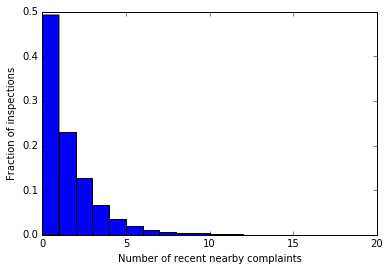

In [229]:
# Distribution of recent nearby sanitation complaints
plt.hist(ncomp_temp[:,1],normed=True,bins=range(20))
plt.ylabel('Fraction of inspections')
plt.xlabel('Number of recent nearby complaints')
plt.show()

In [230]:
# Turn the number of sanitation complaints into a dataframe.  
# Add it to insp.
ncomp = pd.Series(ncomp_temp[:,1],index=ncomp_temp[:,0],name='n_complaints')
insp = pd.concat((insp,ncomp),axis=1)
insp.head(2)

,ID,license,date,Results,Risk,facility,inspection_type,month,day,year,...,Latitude,Longitude,Zip,x,y,zip2,it2,tmax,tavg_week,n_complaints
0,1970470,1909713.0,2016-10-28,1.0,1.0,Restaurant,Short Form Complaint,10,28,2016,...,41.966063,-87.657734,60640.0,28.410576,107.300617,60640.0,Short Form Complaint,65.0,59.0,5.0
4,1970429,1620340.0,2016-10-28,2.0,1.0,Restaurant,Complaint,10,28,2016,...,41.961619,-87.673833,60640.0,27.074279,106.807061,60640.0,Complaint,65.0,59.0,1.0


In [231]:
# Truncate the number of complaints at 10.  For all values over 10, replace them with 10.
# This is because these outcomes are extremely uncommon.
insp['n_comp_trunc']=insp['n_complaints']
insp.ix[insp.n_comp_trunc>10,'n_comp_trunc'] = 10

In [232]:
#(insp.groupby('n_complaints').Results.value_counts(normalize=True)*100).unstack().fillna(0).round(1)
(insp.n_complaints.value_counts(normalize=True)*100).round(1).sort_index()

0.0     49.2
1.0     22.9
2.0     12.8
3.0      6.6
4.0      3.6
5.0      1.9
6.0      1.1
7.0      0.6
8.0      0.4
9.0      0.3
10.0     0.2
11.0     0.1
12.0     0.1
13.0     0.1
14.0     0.0
15.0     0.0
16.0     0.0
17.0     0.0
18.0     0.0
19.0     0.0
20.0     0.0
21.0     0.0
22.0     0.0
23.0     0.0
25.0     0.0
28.0     0.0
29.0     0.0
30.0     0.0
43.0     0.0
Name: n_complaints, dtype: float64

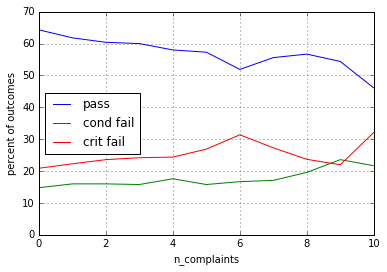

In [233]:
v = (insp.groupby('n_comp_trunc').Results.value_counts(normalize=True)*100).unstack().fillna(0).round(1)
plt.plot(v)
plt.xlabel('n_complaints')
plt.ylabel('percent of outcomes')
plt.legend(('pass','cond fail','crit fail'),loc='best')
plt.ylim([0,70])
plt.grid('on')

Generally, the more complaints, the less likely a pass becomes.  However, this effect is not particularly strong.

# Add weather and sanitation features to the logistic regression model

In [234]:
# isolate the daily high, average weekly high, and sanitation complaints.
# I will model each as a continuous variable.
tmax,tweek,san = insp['tmax'],insp['tavg_week'],insp['n_comp_trunc']

In [241]:
%%time

# Add weather and sanitation features to the inspection features from before

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','tmax','tweek','tmax+tweek','san','all2','all2+tmax',
               'all2+tweek','all2+san','all2+tmax+tweek+san']
n_models = len(model_names)

# Define the predictors for each model
temp = tmax.values.reshape(-1,1)
X1 = temp[~badidx,:].reshape(-1,1)
X0 = (X1[:,0]*0+1).reshape(-1,1)
temp = tweek.values.reshape(-1,1)
X2 = temp[~badidx,:]
temp = pd.concat((tmax,tweek),axis=1).values
X3 = temp[~badidx,:]
temp = san.values.reshape(-1,1)
X4 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy,risk_dummy,ft_dummy),axis=1).values
X5 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy,risk_dummy,ft_dummy,tmax),axis=1).values
X6 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy,risk_dummy,ft_dummy,tweek),axis=1).values
X7 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy,risk_dummy,ft_dummy,san),axis=1).values
X8 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy,risk_dummy,ft_dummy,tweek,tmax,san),axis=1).values
X9 = temp[~badidx,:]

# Aggregate the predictors for all models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 13.1 s


In [242]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

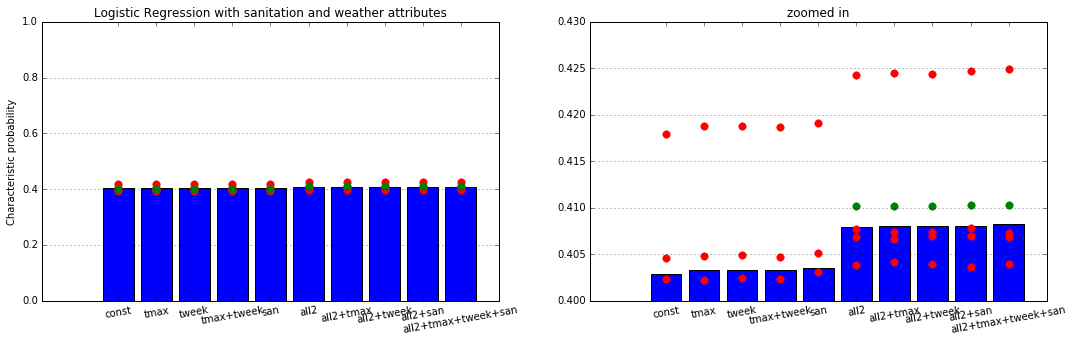

In [243]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with sanitation and weather attributes')
    if i==1:
        plt.ylim([0.40,0.43])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

Surprisingly, the weather ad sanitation features do not add much value to the model.  There is no difference between adding those features in isolation versus the baseline model.  Adding them to the existing inspection features gives no benefit over just the sanitation features alone.

It is possible that:  
(a) The tuning of these features is off. i.e. a week is too long/too short for aggregating temperature, or 0.5km is too big or too small.  
(b) These features interact with the other features but are not important on their own.  e.g. temperature matters in some zips but not others.

In [250]:
%%time

# Add weather and sanitation features to the inspection features from before

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 5
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','zip','san','both','all_zip','all_san','all_both']
n_models = len(model_names)

# Define the predictors for each model
temp = zip_dummy.values
X1 = temp[~badidx,:]
X0 = (X1[:,0]*0+1).reshape(-1,1)
temp = san.values.reshape(-1,1)
X2 = temp[~badidx,:]
temp = pd.concat((zip_dummy,san),axis=1).values
X3 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,it_dummy,risk_dummy,ft_dummy),axis=1).values
X4 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,san,it_dummy,risk_dummy,ft_dummy),axis=1).values
X5 = temp[~badidx,:]
temp = pd.concat((dow_dummy,month_dummy,zip_dummy,san,it_dummy,risk_dummy,ft_dummy),axis=1).values
X6 = temp[~badidx,:]

# Aggregate the predictors for all models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 7.36 s


In [251]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

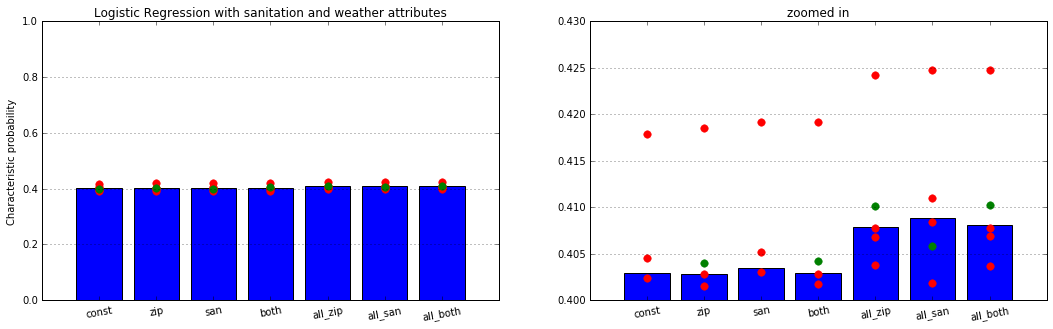

In [252]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with sanitation and weather attributes')
    if i==1:
        plt.ylim([0.40,0.43])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

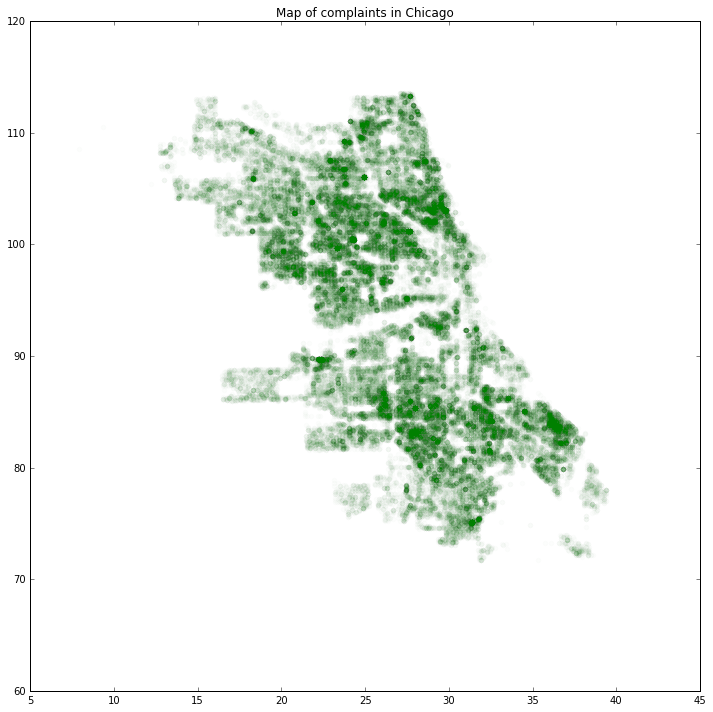

In [256]:
v = comp[['x','y']].values
plt.figure(figsize=(12,12))
plt.scatter(v[:,0],v[:,1],color='g',alpha=0.01)
plt.title("Map of complaints in Chicago")